In [1]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import awswrangler as wr
import boto3
import warnings
import pymysql
import boto3
from scipy.stats import ttest_ind
import scipy.stats as stats
from sqlalchemy import create_engine, text
warnings.filterwarnings('ignore')

# Loading Dataset

In [3]:
# ── Credentials ───────────────────────────────────────────
HOST     = 'AWS database Link'
PORT     = 3306
USER     = 'USERNAME'
PASSWORD = 'PASSWORD' 
DATABASE = 'vendor_sales'

def get_engine():
    engine = create_engine(
        f"mysql+pymysql://{USER}:{PASSWORD}@{HOST}:{PORT}/{DATABASE}"
    )
    return engine

In [4]:
# connecting to database
conn=get_engine()
# fetching vendor sales summary data
df=pd.read_sql_query(""" Select * from vendor_sales_summary""",conn)
df

,VendorNumber,VendorName,Brand,Description,PurchasePrice,ActualPrice,Volume,TotalPurchaseQuantity,TotalPurchaseDollars,TotalSalesQuantity,TotalSalesDollars,TotalSalesPrice,TotalExciseTax,FreightCost,Gross Profit,Profit Margin,Stock Turnover,SalestoPurchaseRatio
0,1128,BROWN-FORMAN CORP,1233,Jack Daniels No 7 Black,26.27,36.99,1750.0,145080.0,3811251.60,142049.0,5.101920e+06,672819.31,260999.20,68601.68,1290667.91,25.297693,0.979108,1.338647
1,4425,MARTIGNETTI COMPANIES,3405,Tito's Handmade Vodka,23.19,28.99,1750.0,164038.0,3804041.22,160247.0,4.819073e+06,561512.37,294438.66,144929.24,1015032.27,21.062810,0.976890,1.266830
2,17035,PERNOD RICARD USA,8068,Absolut 80 Proof,18.24,24.99,1750.0,187407.0,3418303.68,187140.0,4.538121e+06,461140.15,343854.07,123780.22,1119816.92,24.675786,0.998575,1.327594
3,3960,DIAGEO NORTH AMERICA INC,4261,Capt Morgan Spiced Rum,16.17,22.99,1750.0,201682.0,3261197.94,200412.0,4.475973e+06,420050.01,368242.80,257032.07,1214774.94,27.139908,0.993703,1.372493
4,3960,DIAGEO NORTH AMERICA INC,3545,Ketel One Vodka,21.89,29.99,1750.0,138109.0,3023206.01,135838.0,4.223108e+06,545778.28,249587.83,257032.07,1199901.61,28.412764,0.983556,1.396897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10509,9815,WINE GROUP INC,8527,Concannon Glen Ellen Wh Zin,1.32,4.99,750.0,2.0,2.64,5.0,1.595000e+01,10.96,0.55,27100.41,13.31,83.448276,2.500000,6.041667
10510,8004,SAZERAC CO INC,5683,Dr McGillicuddy's Apple Pie,0.39,0.49,50.0,6.0,2.34,134.0,6.566000e+01,1.47,7.04,50293.62,63.32,96.436186,22.333333,28.059829
10511,3924,HEAVEN HILL DISTILLERIES,9123,Deep Eddy Vodka,0.74,0.99,50.0,2.0,1.48,2.0,1.980000e+00,0.99,0.10,14069.87,0.50,25.252525,1.000000,1.337838
10512,3960,DIAGEO NORTH AMERICA INC,6127,The Club Strawbry Margarita,1.47,1.99,200.0,1.0,1.47,72.0,1.432800e+02,77.61,15.12,257032.07,141.81,98.974037,72.000000,97.469388


In [5]:
# ── Step 1: Save DataFrame to CSV locally ─────────────────────
df.to_csv('vendor_sales_summary.csv', index=False) 

# ── Step 2: Set AWS credentials ───────────────────────────────
boto3.setup_default_session(
    aws_access_key_id     = 'S3 BUCKET KEY ID',
    aws_secret_access_key = 'fAWS BUCKET SECRET ACCESS KEY',
    region_name           = 'ap-southeast-1'
)

s3 = boto3.client('s3')
s3.upload_file(
    Filename = 'vendor_sales_summary.csv',
    Bucket   = 'vendor-sales-raw',
    Key      = 'processed/vendor_sales_summary.csv'
)

print("File uploaded to S3!")

File uploaded to S3!


# Exploratory Data Analysis 
- Previously, we examined the various tables in the database to identify key variables, understand their relationships, and determine which ones should be included in the final analysis.

- In this phase of EDA, we will analyze the resultant table to gain insights into the distribution of each column. This will help us understand data patterns, identify anomalies, and ensure data quality before proceeding with further analysis.


In [7]:
# Summary statistics for numerical columns
df.describe().T

,count,mean,std,min,25%,50%,75%,max
VendorNumber,10514.0,10600.166255,18661.457769,2.000000,3924.000000,7153.000000,9552.000000,2.013590e+05
Brand,10514.0,17975.340784,12689.342924,58.000000,5716.750000,18644.000000,25465.750000,9.063100e+04
PurchasePrice,10514.0,23.409368,92.170052,0.360000,6.840000,10.450000,19.370000,4.264700e+03
ActualPrice,10514.0,34.340224,126.674964,0.490000,10.990000,15.990000,28.990000,5.799990e+03
Volume,10514.0,847.736732,667.959671,50.000000,750.000000,750.000000,750.000000,2.000000e+04
TotalPurchaseQuantity,10514.0,3192.852007,11181.338139,1.000000,36.000000,280.500000,2028.750000,3.376600e+05
TotalPurchaseDollars,10514.0,30589.555058,124047.851341,0.710000,479.362500,3836.415000,21280.710000,3.811252e+06
TotalSalesQuantity,10514.0,3129.583317,11037.801407,1.000000,36.000000,280.000000,1985.000000,3.349390e+05
TotalSalesDollars,10514.0,42954.173834,168977.755843,1.980000,809.820000,5599.700000,29524.250000,5.101920e+06
TotalSalesPrice,10514.0,19111.958773,45264.605387,0.990000,334.890000,3020.085000,16442.477500,6.728193e+05


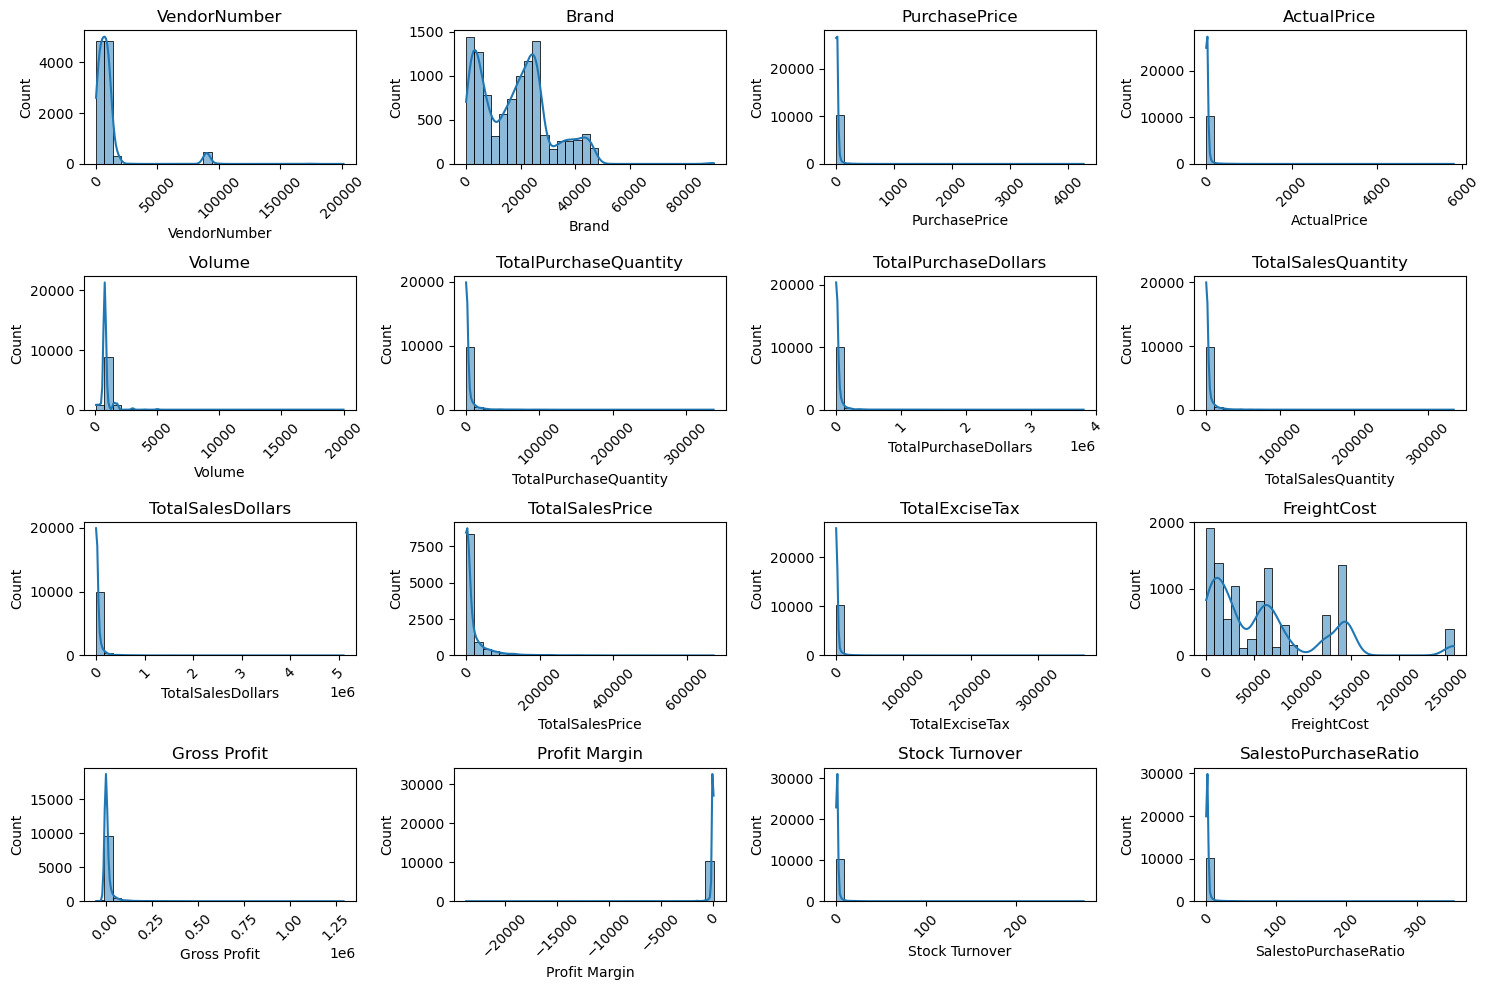

In [8]:
# Distribution Plots for Numerical Columns
numerical_cols=df.select_dtypes(include=np.number).columns
plt.figure(figsize=(15,10))
for i,col in enumerate(numerical_cols):
    plt.subplot(4,4,i+1)
    sns.histplot(df[col],kde=True,bins=30)
    plt.title(col)
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

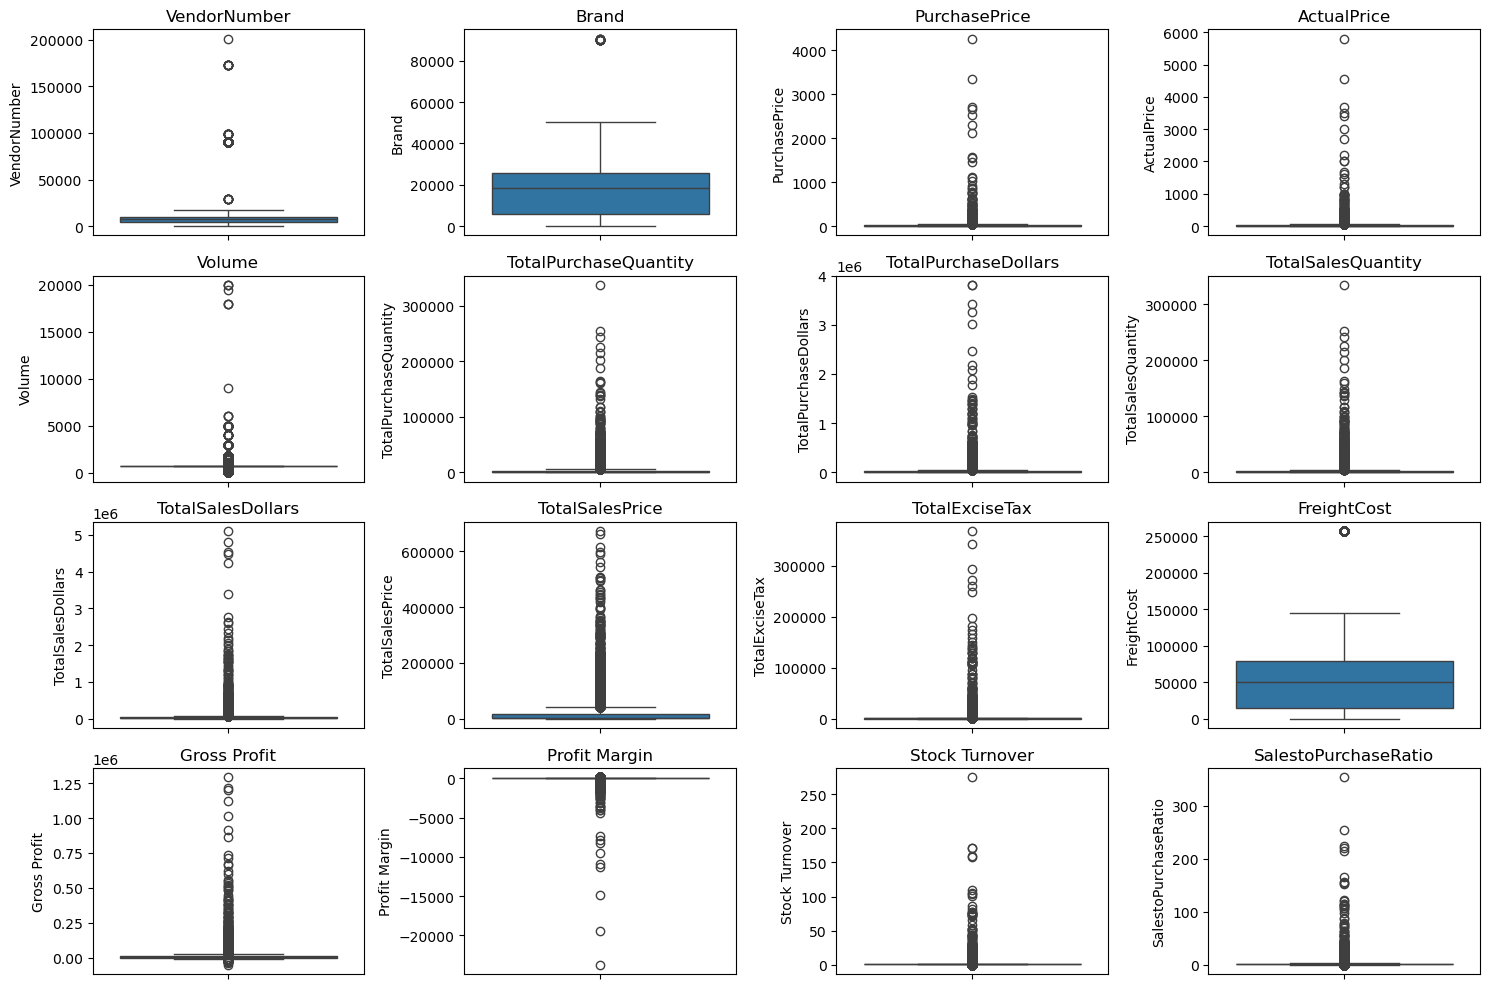

In [9]:
# Outlier Detection with Boxplots
plt.figure(figsize=(15,10))
for i,col in enumerate(numerical_cols):
    plt.subplot(4,4,i+1)
    sns.boxplot(df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

## Summary Statistics Insights:
**Negative & Zero Values:**

- Gross Profit: Minimum value is -52,002.78, indicating losses. Some products or transactions may be selling at a loss due to high costs or selling at discounts lower than the purchase price..
- Profit Margin: Has a minimum of -∞, which suggests cases where revenue is zero or even lower than costs.
- Total Sales Quantity & Sales Dollars: Minimum values are 0, meaning some products were purchased but never sold. These could be slow-moving or obsolete stock.

**Outliers Indicated by High Standard Deviations:**

- Purchase & Actual Prices: The max values (5,681.81 & 7,499.99) are significantly higher than the mean (24.39 & 35.64), indicating potential premium products.
- Freight Cost: Huge variation, from 0.09 to 257,032.07, suggests logistics inefficiencies or bulk shipments.
- Stock Turnover: Ranges from 0 to 274.5, implying some products sell extremely fast while others remain in stock indefinitely. Value more than 1 indicates that Sold quantity for that product is higher than purchased quantity due to either sales are being fulfilled from older stock.

In [11]:
# # let's filter the data by removing inconsistencies
df=pd.read_sql_query(""" Select * from vendor_sales_summary where `Gross profit` > 0 and `Profit margin`>0 and TotalSalesQuantity>0 """,conn)
df

,VendorNumber,VendorName,Brand,Description,PurchasePrice,ActualPrice,Volume,TotalPurchaseQuantity,TotalPurchaseDollars,TotalSalesQuantity,TotalSalesDollars,TotalSalesPrice,TotalExciseTax,FreightCost,Gross Profit,Profit Margin,Stock Turnover,SalestoPurchaseRatio
0,1128,BROWN-FORMAN CORP,1233,Jack Daniels No 7 Black,26.27,36.99,1750.0,145080.0,3811251.60,142049.0,5.101920e+06,672819.31,260999.20,68601.68,1290667.91,25.297693,0.979108,1.338647
1,4425,MARTIGNETTI COMPANIES,3405,Tito's Handmade Vodka,23.19,28.99,1750.0,164038.0,3804041.22,160247.0,4.819073e+06,561512.37,294438.66,144929.24,1015032.27,21.062810,0.976890,1.266830
2,17035,PERNOD RICARD USA,8068,Absolut 80 Proof,18.24,24.99,1750.0,187407.0,3418303.68,187140.0,4.538121e+06,461140.15,343854.07,123780.22,1119816.92,24.675786,0.998575,1.327594
3,3960,DIAGEO NORTH AMERICA INC,4261,Capt Morgan Spiced Rum,16.17,22.99,1750.0,201682.0,3261197.94,200412.0,4.475973e+06,420050.01,368242.80,257032.07,1214774.94,27.139908,0.993703,1.372493
4,3960,DIAGEO NORTH AMERICA INC,3545,Ketel One Vodka,21.89,29.99,1750.0,138109.0,3023206.01,135838.0,4.223108e+06,545778.28,249587.83,257032.07,1199901.61,28.412764,0.983556,1.396897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8560,9815,WINE GROUP INC,8527,Concannon Glen Ellen Wh Zin,1.32,4.99,750.0,2.0,2.64,5.0,1.595000e+01,10.96,0.55,27100.41,13.31,83.448276,2.500000,6.041667
8561,8004,SAZERAC CO INC,5683,Dr McGillicuddy's Apple Pie,0.39,0.49,50.0,6.0,2.34,134.0,6.566000e+01,1.47,7.04,50293.62,63.32,96.436186,22.333333,28.059829
8562,3924,HEAVEN HILL DISTILLERIES,9123,Deep Eddy Vodka,0.74,0.99,50.0,2.0,1.48,2.0,1.980000e+00,0.99,0.10,14069.87,0.50,25.252525,1.000000,1.337838
8563,3960,DIAGEO NORTH AMERICA INC,6127,The Club Strawbry Margarita,1.47,1.99,200.0,1.0,1.47,72.0,1.432800e+02,77.61,15.12,257032.07,141.81,98.974037,72.000000,97.469388


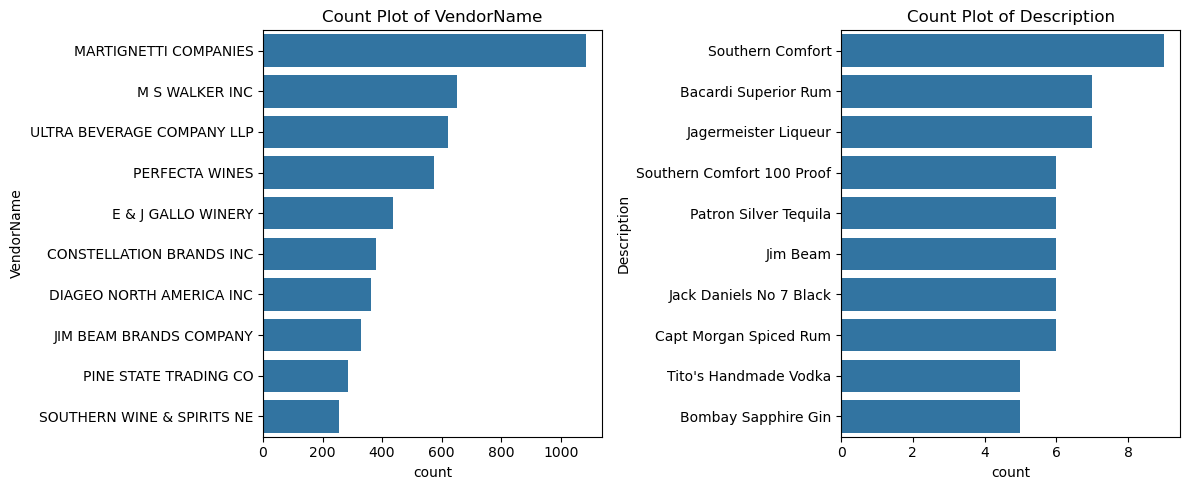

In [12]:
# Count Plots for Categorical Columns
categorical_col=["VendorName","Description"]
plt.figure(figsize=(12,5))
for i,col in enumerate(categorical_col):
    plt.subplot(1,2,i+1)
    sns.countplot(y=df[col],order=df[col].value_counts().index[:10])
    plt.title(f"Count Plot of {col}")
plt.tight_layout()

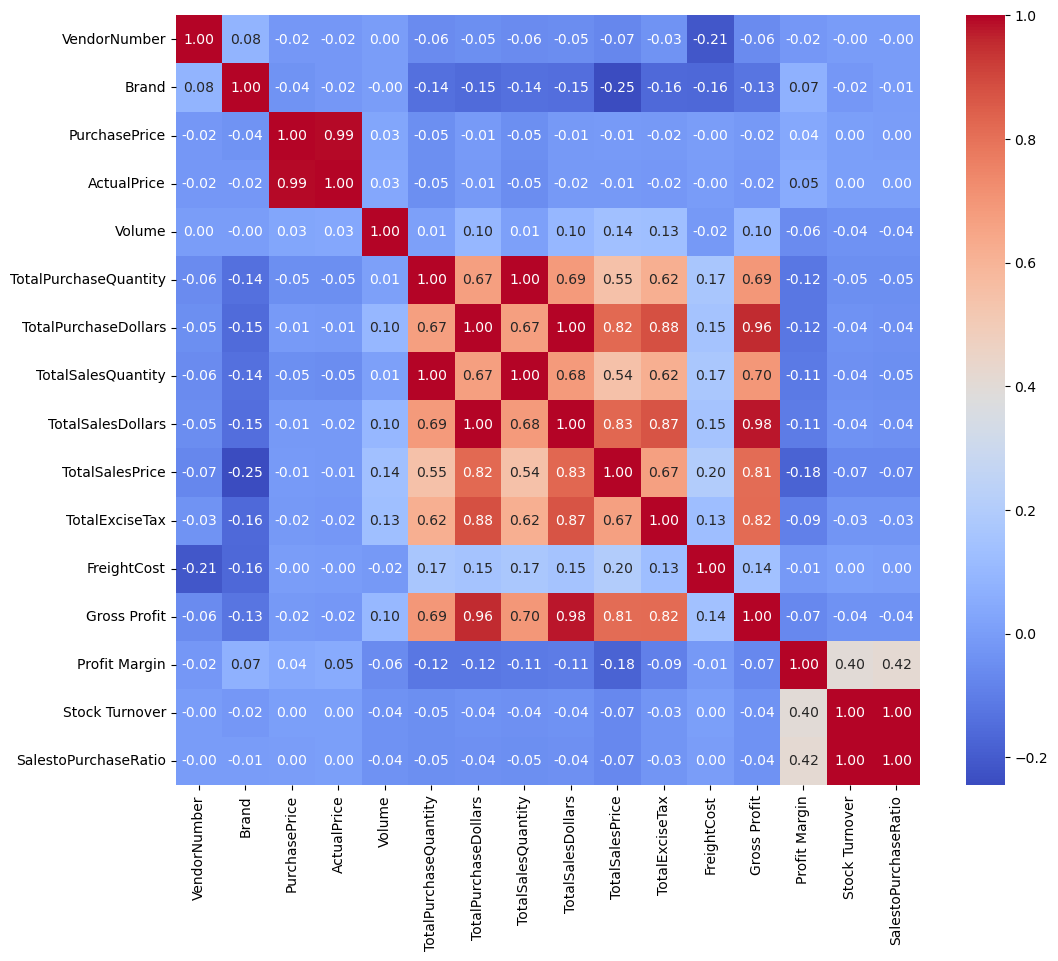

In [13]:
# Correlation Heatmap
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(numeric_only=True),annot=True,cmap="coolwarm",fmt=".2f")
plt.show()

## Correlation Insights
- Purchase Price has weak correlations with TotalSales Dollars (-0.012) and Gross Profit (-0.016), suggesting that price variations do not significantly impact sales revenue or profit.
- Strong correlation between total purchase quantity and total sales quantity (0.999), confirming efficient inventory turnover.
- Negative correlation between profit margin & total sales price (-0.179) suggests that as sales price increases, margins decrease, possibly due to competitive pricing pressures.
- StockTurnover has weak negative correlations with both Gross Profit (-0.038) and ProfitMargin (-0.055), indicating that faster turnover does not necessarily result in higher profitability.

## Data Analysis

### Identify Brands that need Promotional or Pricing Adjustment which exhibit lower sales performance but higher profit margins

In [17]:
brand_performance=df.groupby('Description').agg({'TotalSalesDollars':'sum','Profit Margin':'sum'}).reset_index()

In [18]:
# threshold for "low sales" (bottom 15%) and "high margin" (top 15%)
low_sales_threshold=brand_performance['TotalSalesDollars'].quantile(0.15)
high_margin_threshold=brand_performance['Profit Margin'].quantile(0.85)

In [19]:
low_sales_threshold

560.299

In [20]:
high_margin_threshold

73.53875892464183

In [21]:
# Filter brands with low sales but high profit margins
target_brands=brand_performance[
(brand_performance['TotalSalesDollars']<=low_sales_threshold) &
 (brand_performance['Profit Margin']>=high_margin_threshold)
 ]
print("Brands with low Sales but High Margins:")
display(target_brands.sort_values('TotalSalesDollars'))

Brands with low Sales but High Margins:


,Description,TotalSalesDollars,Profit Margin
2070,Concannon Glen Ellen Wh Zin,15.95,83.448276
2188,Crown Royal Apple,27.86,89.806174
6237,Sauza Sprklg Wild Berry Marg,27.96,82.153076
7184,Tracia Syrah,44.94,88.495772
600,Basilica Amaretto,47.45,85.079031
...,...,...,...
4075,Kennedy's Original Irish,527.67,89.178843
1778,Ch Thivin Cote de Brouilly,528.77,85.314976
202,Altadonna Vermentino,530.41,96.493279
5074,Nanbu Bijin Southern Beauty,535.68,76.747312


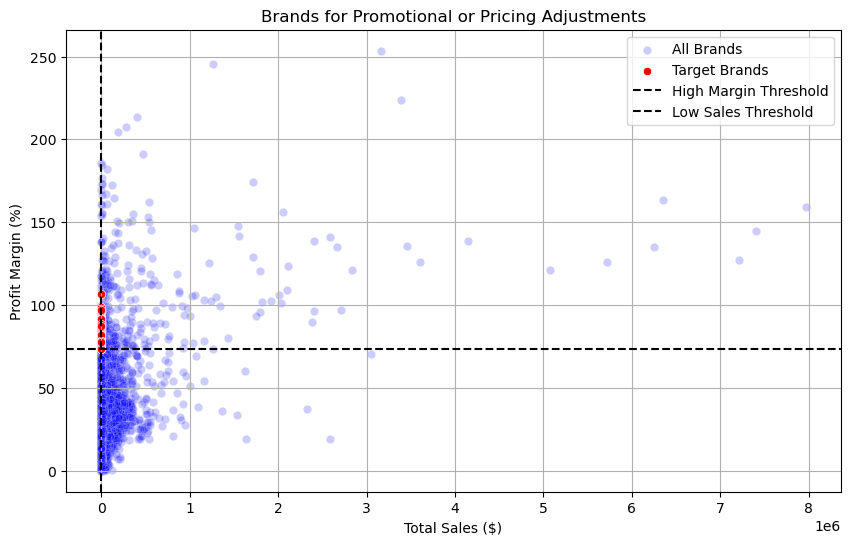

In [22]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=brand_performance, x='TotalSalesDollars', y='Profit Margin', color="blue", label="All Brands", alpha = 0.2)
sns.scatterplot(data=target_brands, x='TotalSalesDollars', y='Profit Margin', color="red", label="Target Brands")

plt.axhline(high_margin_threshold, linestyle='--', color='black', label="High Margin Threshold")
plt.axvline(low_sales_threshold, linestyle='--', color='black', label="Low Sales Threshold")

plt.xlabel("Total Sales ($)")
plt.ylabel("Profit Margin (%)")
plt.title("Brands for Promotional or Pricing Adjustments")
plt.legend()
plt.grid(True)
plt.show()

#### Which vendors and brands demonstrate the highest sales performance?

In [24]:
def format_dollars(value):
    if value>=1_000_000:
        return f"{value/1_000_000:.2f}M"
    elif value>=1_000:
        return f"{value/1_000:.2f}K"
    else:
        return f"{value:.2f}"

In [25]:
# Top Vendors & Brands by Sales Performance
top_vendors=df.groupby("VendorName")["TotalSalesDollars"].sum().nlargest(10)
top_brands=df.groupby("Description")["TotalSalesDollars"].sum().nlargest(10)

In [26]:
top_brands

Description
Jack Daniels No 7 Black    7964746.76
Tito's Handmade Vodka      7399657.58
Grey Goose Vodka           7209608.06
Capt Morgan Spiced Rum     6356320.62
Absolut 80 Proof           6244752.03
Jameson Irish Whiskey      5715759.69
Ketel One Vodka            5070083.56
Baileys Irish Cream        4150122.07
Kahlua                     3604858.66
Tanqueray                  3456697.90
Name: TotalSalesDollars, dtype: float64

In [27]:
top_vendors

VendorName
DIAGEO NORTH AMERICA INC      6.799010e+07
MARTIGNETTI COMPANIES         3.933036e+07
PERNOD RICARD USA             3.206320e+07
JIM BEAM BRANDS COMPANY       3.142302e+07
BACARDI USA INC               2.485482e+07
CONSTELLATION BRANDS INC      2.421875e+07
E & J GALLO WINERY            1.839990e+07
BROWN-FORMAN CORP             1.824723e+07
ULTRA BEVERAGE COMPANY LLP    1.650254e+07
M S WALKER INC                1.470646e+07
Name: TotalSalesDollars, dtype: float64

In [28]:
top_brands.apply(lambda x:format_dollars(x))

Description
Jack Daniels No 7 Black    7.96M
Tito's Handmade Vodka      7.40M
Grey Goose Vodka           7.21M
Capt Morgan Spiced Rum     6.36M
Absolut 80 Proof           6.24M
Jameson Irish Whiskey      5.72M
Ketel One Vodka            5.07M
Baileys Irish Cream        4.15M
Kahlua                     3.60M
Tanqueray                  3.46M
Name: TotalSalesDollars, dtype: object

In [29]:
top_vendors.apply(lambda x:format_dollars(x))

VendorName
DIAGEO NORTH AMERICA INC      67.99M
MARTIGNETTI COMPANIES         39.33M
PERNOD RICARD USA             32.06M
JIM BEAM BRANDS COMPANY       31.42M
BACARDI USA INC               24.85M
CONSTELLATION BRANDS INC      24.22M
E & J GALLO WINERY            18.40M
BROWN-FORMAN CORP             18.25M
ULTRA BEVERAGE COMPANY LLP    16.50M
M S WALKER INC                14.71M
Name: TotalSalesDollars, dtype: object

In [30]:
# dollars=['TotalPurchaseDollars','TotalSalesDollars','TotalSalesPrice','TotalExciseTax','FreightCost','Gross Profit']
# for i in dollars:
#     df[i]=df[i].apply(lambda x:format_dollars(x))

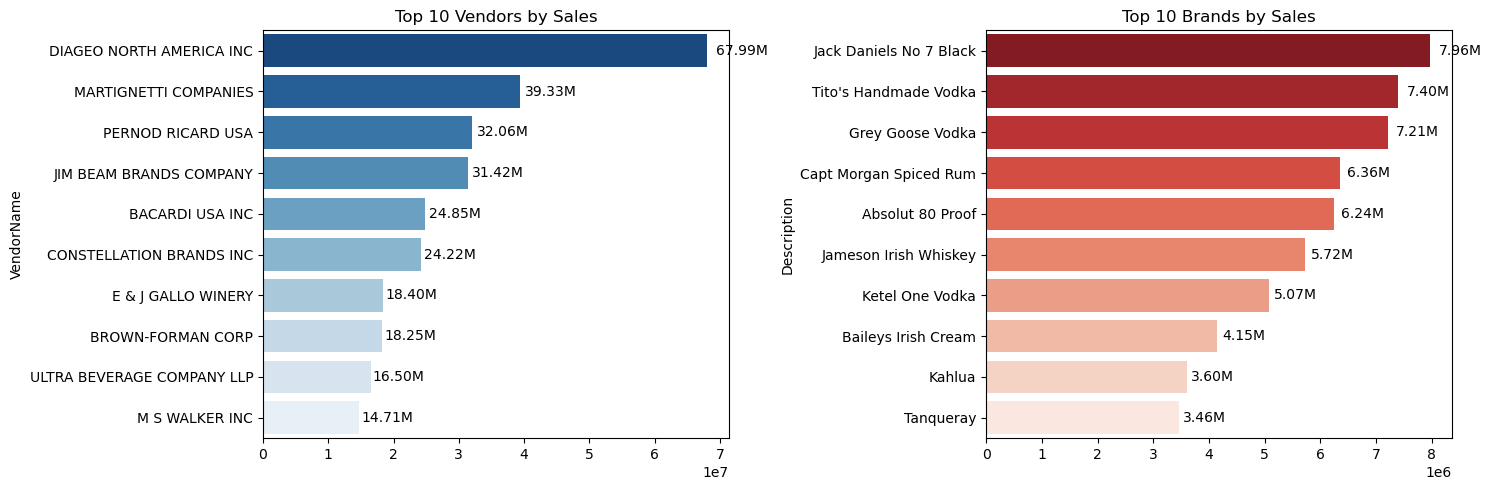

In [31]:
plt.figure(figsize=(15, 5))

# Plot for Top Vendors
plt.subplot(1, 2, 1)
ax1 = sns.barplot(y=top_vendors.index,x=top_vendors.values,palette="Blues_r")
plt.title("Top 10 Vendors by Sales")

for bar in ax1.patches:
    ax1.text(bar.get_width() + (bar.get_width() * 0.02),bar.get_y() + bar.get_height() / 2,format_dollars(bar.get_width()),ha='left',va='center',fontsize=10,color='black')

# Plot for Top Brands
plt.subplot(1, 2, 2)
ax2 = sns.barplot(y=top_brands.index.astype(str),x=top_brands.values,palette="Reds_r")
plt.title("Top 10 Brands by Sales")

for bar in ax2.patches:
    ax2.text(bar.get_width() + (bar.get_width() * 0.02),bar.get_y() + bar.get_height() / 2,format_dollars(bar.get_width()),ha='left',va='center',fontsize=10,color='black'
    )
plt.tight_layout()
plt.show()

## Which Vendors Contribute the most to total Dollar Purchase?

In [33]:
vendor_performance=df.groupby('VendorName').agg({'TotalPurchaseDollars':'sum','Gross Profit':'sum','TotalSalesDollars':'sum'}).reset_index()

In [34]:
vendor_performance['PurchaseContribution%']=vendor_performance['TotalPurchaseDollars']/vendor_performance['TotalPurchaseDollars'].sum()*100

In [35]:
round(vendor_performance.sort_values('PurchaseContribution%',ascending=False),2)

,VendorName,TotalPurchaseDollars,Gross Profit,TotalSalesDollars,PurchaseContribution%
25,DIAGEO NORTH AMERICA INC,50097226.16,17892873.26,67990099.42,16.30
57,MARTIGNETTI COMPANIES,25502095.83,13828263.53,39330359.36,8.30
68,PERNOD RICARD USA,23851164.17,8212032.02,32063196.19,7.76
46,JIM BEAM BRANDS COMPANY,23494304.32,7928716.14,31423020.46,7.64
6,BACARDI USA INC,17432020.26,7422796.88,24854817.14,5.67
...,...,...,...,...,...
33,FANTASY FINE WINES CORP,128.64,198.95,327.59,0.00
107,UNCORKED,118.74,58.20,176.94,0.00
85,SILVER MOUNTAIN CIDERS,77.18,265.33,342.51,0.00
16,CAPSTONE INTERNATIONAL,54.64,192.23,246.87,0.00


In [36]:
# Display Top 10 vendors
top_vendors=round(vendor_performance.sort_values('PurchaseContribution%',ascending=False),2).head(10)
top_vendors['TotalPurchaseDollars']=top_vendors['TotalPurchaseDollars'].apply(format_dollars)
top_vendors['Gross Profit']=top_vendors['Gross Profit'].apply(format_dollars)
top_vendors['TotalSalesDollars']=top_vendors['TotalSalesDollars'].apply(format_dollars)
top_vendors['Cummalative PurchaseContribution%']=top_vendors['PurchaseContribution%'].cumsum()

In [37]:
top_vendors

,VendorName,TotalPurchaseDollars,Gross Profit,TotalSalesDollars,PurchaseContribution%,Cummalative PurchaseContribution%
25,DIAGEO NORTH AMERICA INC,50.10M,17.89M,67.99M,16.30,16.30
57,MARTIGNETTI COMPANIES,25.50M,13.83M,39.33M,8.30,24.60
68,PERNOD RICARD USA,23.85M,8.21M,32.06M,7.76,32.36
46,JIM BEAM BRANDS COMPANY,23.49M,7.93M,31.42M,7.64,40.00
6,BACARDI USA INC,17.43M,7.42M,24.85M,5.67,45.67
20,CONSTELLATION BRANDS INC,15.27M,8.95M,24.22M,4.97,50.64
11,BROWN-FORMAN CORP,13.24M,5.01M,18.25M,4.31,54.95
30,E & J GALLO WINERY,12.07M,6.33M,18.40M,3.93,58.88
106,ULTRA BEVERAGE COMPANY LLP,11.17M,5.34M,16.50M,3.63,62.51
53,M S WALKER INC,9.76M,4.94M,14.71M,3.18,65.69


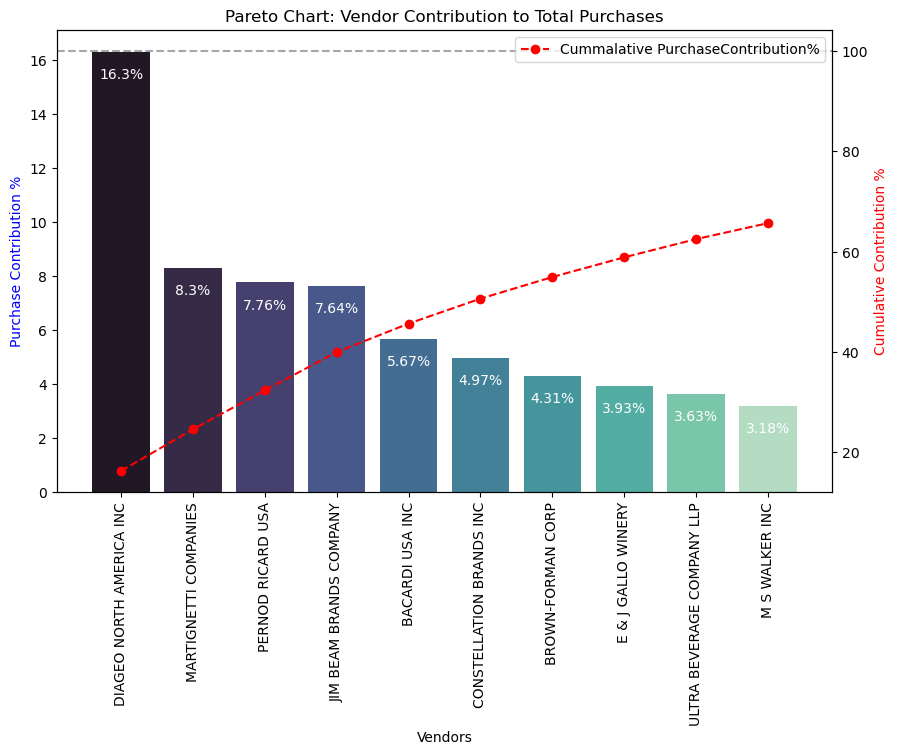

In [38]:
fig,ax1=plt.subplots(figsize=(10,6))
sns.barplot(x=top_vendors['VendorName'],y=top_vendors['PurchaseContribution%'],palette="mako",ax=ax1)
for i,value in enumerate(top_vendors['PurchaseContribution%']):
    ax1.text(i,value-1,str(value)+'%',ha='center',fontsize=10,color='white')

#Line Plot for Cumulative Contribution%
ax2=ax1.twinx()
ax2.plot(top_vendors['VendorName'], top_vendors['Cummalative PurchaseContribution%'], color='red', marker='o', linestyle='dashed', label='Cummalative PurchaseContribution%')
ax1.set_xticklabels (top_vendors ['VendorName'], rotation=90)
ax1.set_ylabel('Purchase Contribution %', color='blue')
ax2.set_ylabel('Cumulative Contribution %', color='red')
ax1.set_xlabel('Vendors')
ax1.set_title('Pareto Chart: Vendor Contribution to Total Purchases')
ax2.axhline(y=100, color='gray', linestyle='dashed', alpha=0.7)
ax2. legend (loc='upper right')

plt.show()

## How much of total procurement is dependent on the top vendors?

In [40]:
print(f"Total Purchase Contribution of top 10 vendors is {round(top_vendors ['PurchaseContribution%'].sum(),2)}%")

Total Purchase Contribution of top 10 vendors is 65.69%


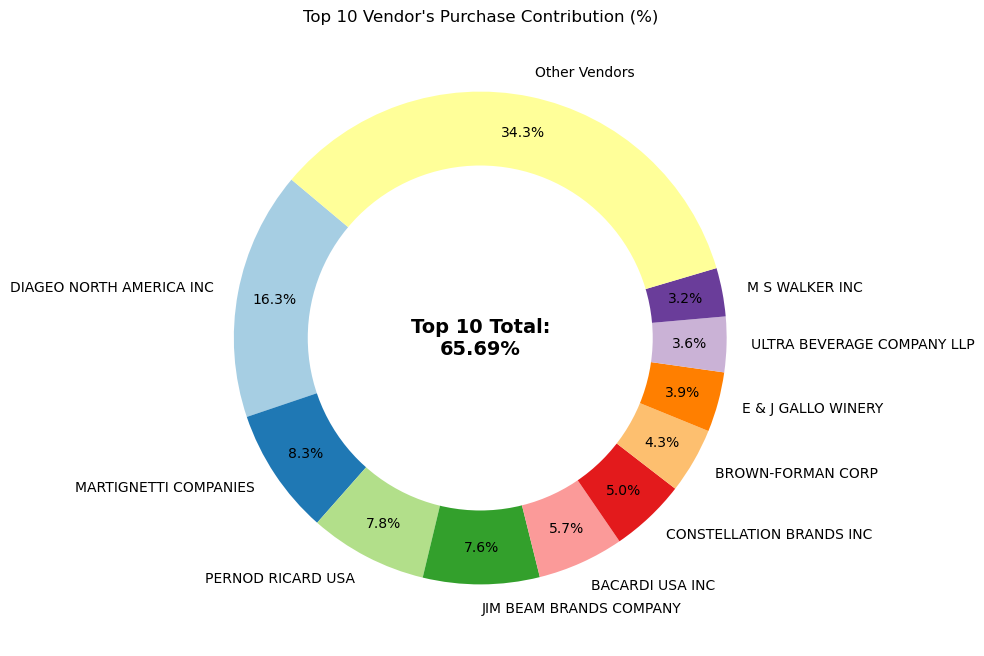

In [41]:
vendors = list(top_vendors['VendorName'].values)
purchase_contributions = list(top_vendors ['PurchaseContribution%'].values)
total_contribution = sum(purchase_contributions)
remaining_contribution = 100-total_contribution
# Append "Other Vendors" category
vendors.append("Other Vendors")
purchase_contributions.append(remaining_contribution)

# Donut Chart
fig, ax = plt.subplots (figsize=(8, 8))
wedges, texts, autotexts = ax.pie(purchase_contributions, labels=vendors, autopct='%1.1f%%',startangle=140, pctdistance=0.85, colors=plt.cm.Paired.colors)

#Draw a white circle in the center to create a "donut" effect
centre_circle = plt.Circle ((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)
#Add Total Contribution annotation in the center

plt.text(0, 0, f"Top 10 Total:\n{total_contribution:.2f}%", fontsize=14, fontweight='bold', ha='center', va='center')
plt.title("Top 10 Vendor's Purchase Contribution (%)")
plt.show()

The remaining vendors contribute only 34.31%, meaning they are not utilized effectively or may not be as competitive.
If vendor dependency is too high, consider identifying new suppliers to reduce risk.

#### Does purchasing in bulk reduce the unit price, and what is the optimal purchase volume for cost savings?

In [44]:
# Calculate Unit Purchase Price per Vendor & Volume Group
df['UnitPurchasePrice']=df['TotalPurchaseDollars']/df['TotalPurchaseQuantity']


In [45]:
# Group by Order Sizes (e.g., Small, Medium, Large Purchases)
df['OrderSize']=pd.qcut(df['TotalPurchaseQuantity'],q=3,labels=["Small","Medium","Large"])

In [46]:
df['OrderSize']

0       Large
1       Large
2       Large
3       Large
4       Large
        ...  
8560    Small
8561    Small
8562    Small
8563    Small
8564    Small
Name: OrderSize, Length: 8565, dtype: category
Categories (3, object): ['Small' < 'Medium' < 'Large']

In [47]:
# Analyze Cost Savings per Order Size
bulk_purchase_analysis = df.groupby("OrderSize")["UnitPurchasePrice"].mean().reset_index()
print(bulk_purchase_analysis)

  OrderSize  UnitPurchasePrice
0     Small          39.057543
1    Medium          15.486414
2     Large          10.777625


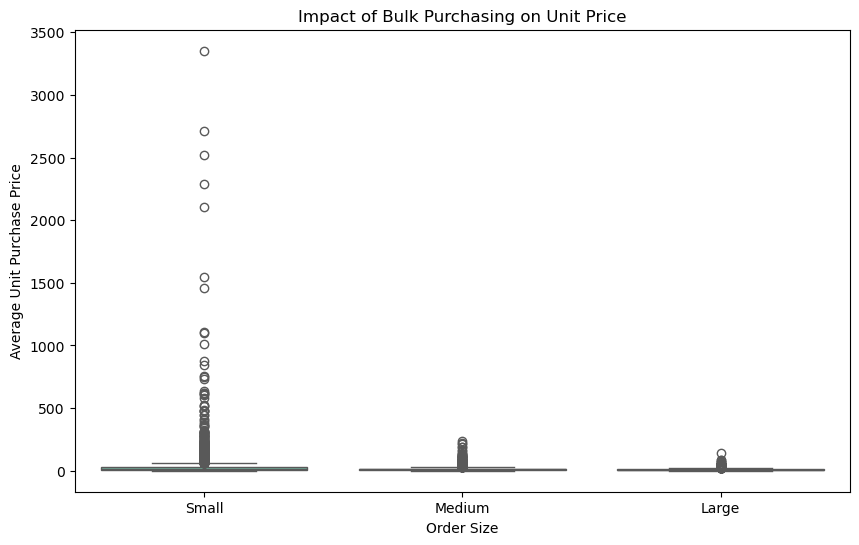

In [48]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x="OrderSize", y="UnitPurchasePrice", palette="Set2")
plt.title("Impact of Bulk Purchasing on Unit Price")
plt.xlabel("Order Size")
plt.ylabel("Average Unit Purchase Price")
plt.show()

- Vendors buying in bulk (Large Order Size) get the lowest unit price ($10.78 per unit), meaning higher margins if they can manage inventory efficiently.
- The price difference between Small and Large orders is substantial (~72% reduction in unit cost).
- This suggests that bulk pricing strategies successfully encourage vendors to purchase in larger volumes, leading to higher overall sales despite lower per-unit revenue.

## Which vendors have low inventory turnover, indicating excess stock and slow-moving products?

In [51]:
# Identify Low Inventory Turnover Vendors
df[df['Stock Turnover']<100].groupby('VendorName')[['Stock Turnover']].mean().sort_values('Stock Turnover',ascending=True).head(10)

,Stock Turnover
VendorName,
TAMWORTH DISTILLING,0.797078
WALPOLE MTN VIEW WINERY,0.820548
SWEETWATER FARM,0.851047
BRONCO WINE COMPANY,0.866951
AMERICAN SPIRITS EXCHANGE,0.875000
SWEET BABY VINEYARD,0.876638
FULCHINO VINEYARD INC,0.879957
SOUTHERN GLAZERS W&S OF NE,0.883701
CENTEUR IMPORTS LLC,0.886976


## How much capital is locked in unsold inventory per vendor, and which vendors contribute the most to it?

In [53]:
# Calculate Unsold Inventory Value
df ["UnsoldInventoryValue"] = (df["TotalPurchaseQuantity"]-df["TotalSalesQuantity"])*df["PurchasePrice"]
print('Total Unsold Capital:', format_dollars (df["UnsoldInventoryValue"].sum()))

Total Unsold Capital: 2.71M


In [54]:
df.head(1)

,VendorNumber,VendorName,Brand,Description,PurchasePrice,ActualPrice,Volume,TotalPurchaseQuantity,TotalPurchaseDollars,TotalSalesQuantity,...,TotalSalesPrice,TotalExciseTax,FreightCost,Gross Profit,Profit Margin,Stock Turnover,SalestoPurchaseRatio,UnitPurchasePrice,OrderSize,UnsoldInventoryValue
0,1128,BROWN-FORMAN CORP,1233,Jack Daniels No 7 Black,26.27,36.99,1750.0,145080.0,3811251.6,142049.0,...,672819.31,260999.2,68601.68,1290667.91,25.297693,0.979108,1.338647,26.27,Large,79624.37


In [55]:
#Aggregate Capital Locked per Vendor
inventory_value_per_vendor = df.groupby("VendorName")["UnsoldInventoryValue"].sum().reset_index()

#Sort Vendors with the Highest Locked Capital

inventory_value_per_vendor=inventory_value_per_vendor.sort_values (by="UnsoldInventoryValue", ascending=False)
inventory_value_per_vendor['UnsoldInventoryValue']=inventory_value_per_vendor['UnsoldInventoryValue'].apply(format_dollars)
inventory_value_per_vendor.head(10)

,VendorName,UnsoldInventoryValue
25,DIAGEO NORTH AMERICA INC,722.21K
46,JIM BEAM BRANDS COMPANY,554.67K
68,PERNOD RICARD USA,470.63K
116,WILLIAM GRANT & SONS INC,401.96K
30,E & J GALLO WINERY,228.28K
79,SAZERAC CO INC,198.44K
11,BROWN-FORMAN CORP,177.73K
20,CONSTELLATION BRANDS INC,133.62K
61,MOET HENNESSY USA INC,126.48K
77,REMY COINTREAU USA INC,118.60K


## What is the 95% confidence intervals for profit margins of top-performing and low-performing vendors.

In [57]:
# Define top and low vendors based on Total Sales Dollars (Top 25% & Bottom 25%)
top_threshold=df["TotalSalesDollars"].quantile(0.75)
low_threshold=df["TotalSalesDollars"].quantile(0.25)

In [58]:
top_vendors=df[df["TotalSalesDollars"] >= top_threshold] ["Profit Margin"].dropna() 
low_vendors=df[df["TotalSalesDollars"] <=low_threshold] ["Profit Margin"].dropna()

In [59]:
top_vendors

0       25.297693
1       21.062810
2       24.675786
3       27.139908
4       28.412764
          ...    
3523    79.684817
3681    85.782102
4751    93.085860
4920    95.012530
5050    94.271857
Name: Profit Margin, Length: 2142, dtype: float64

In [60]:
low_vendors

5631     4.111764
5652     6.145626
5701    12.007271
5704     1.677308
5724     7.239599
          ...    
8560    83.448276
8561    96.436186
8562    25.252525
8563    98.974037
8564    99.166079
Name: Profit Margin, Length: 2142, dtype: float64

In [61]:
# Function to compute confidence interval
def confidence_interval(data, confidence=0.95):
    mean_val = np.mean(data)
    std_err = np.std(data, ddof=1) / np.sqrt(len(data))
    t_critical = stats.t.ppf((1 + confidence) / 2, df=len(data) - 1)
    margin_of_error = t_critical * std_err

    return mean_val, mean_val - margin_of_error, mean_val + margin_of_error

Top Vendors 95% CI: (30.74, 31.61), Mean: 31.17
Low Vendors 95% CI: (40.48, 42.62), Mean: 41.55


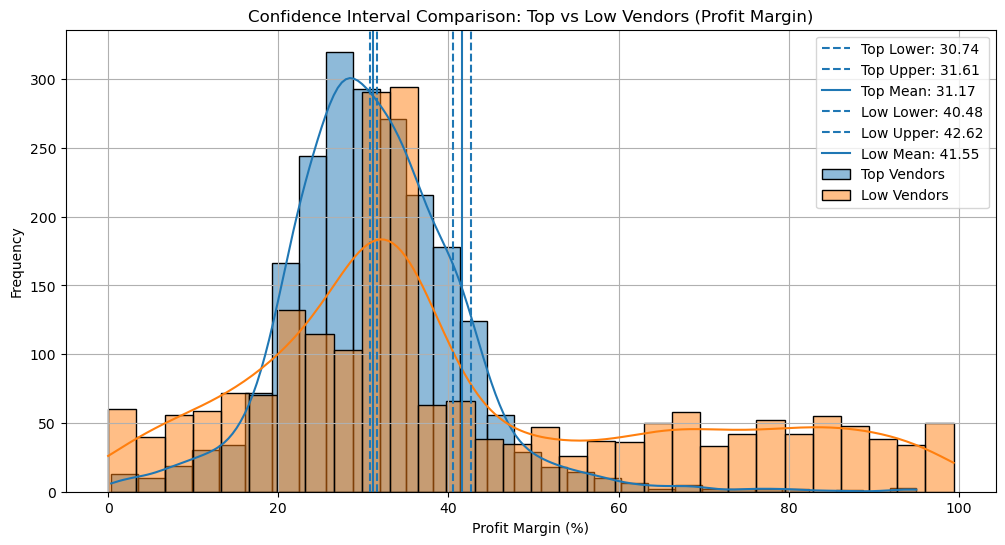

In [62]:
# Calculate confidence intervals
top_mean, top_lower, top_upper = confidence_interval(top_vendors)
low_mean, low_lower, low_upper = confidence_interval(low_vendors)

# Print results
print(f"Top Vendors 95% CI: ({top_lower:.2f}, {top_upper:.2f}), Mean: {top_mean:.2f}")
print(f"Low Vendors 95% CI: ({low_lower:.2f}, {low_upper:.2f}), Mean: {low_mean:.2f}")

# Plot
plt.figure(figsize=(12, 6))

# Top Vendors Plot
sns.histplot(top_vendors, kde=True, bins=30, alpha=0.5, label="Top Vendors")
plt.axvline(top_lower, linestyle="--", label=f"Top Lower: {top_lower:.2f}")
plt.axvline(top_upper, linestyle="--", label=f"Top Upper: {top_upper:.2f}")
plt.axvline(top_mean, linestyle="-", label=f"Top Mean: {top_mean:.2f}")

# Low Vendors Plot
sns.histplot(low_vendors, kde=True, bins=30, alpha=0.5, label="Low Vendors")
plt.axvline(low_lower, linestyle="--", label=f"Low Lower: {low_lower:.2f}")
plt.axvline(low_upper, linestyle="--", label=f"Low Upper: {low_upper:.2f}")
plt.axvline(low_mean, linestyle="-", label=f"Low Mean: {low_mean:.2f}")

# Finalize Plot
plt.title("Confidence Interval Comparison: Top vs Low Vendors (Profit Margin)")
plt.xlabel("Profit Margin (%)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()


- The confidence interval for low-performing vendors (40.48% to 42.62%) is significantly higher than that of top-performing vendors (30.74% to 31.61%).
- This suggests that vendors with lower sales tend to maintain higher profit margins, potentially due to premium pricing or lower operational costs.
- For High-Performing Vendors: If they aim to improve profitability, they could explore selective price adjustments, cost optimization, or bundling strategies.
- For Low-Performing Vendors: Despite higher margins, their low sales volume might indicate a need for better marketing, competitive pricing, or improved distribution strategies.

#### Is there a significant difference in profit margins between top-performing and low-performing vendors?

Hypothesis:

H₀ (Null Hypothesis): There is no significant difference in the mean profit margins of top-performing and low-performing vendors.

H₁ (Alternative Hypothesis): The mean profit margins of top-performing and low-performing vendors are significantly different.

In [65]:

top_threshold = df["TotalSalesDollars"].quantile(0.75)
low_threshold = df["TotalSalesDollars"].quantile(0.25)

top_vendors = df[df["TotalSalesDollars"] >= top_threshold]["Profit Margin"].dropna()
low_vendors = df[df["TotalSalesDollars"] <= low_threshold]["Profit Margin"].dropna()

# Perform Two-Sample T-Test
t_stat, p_value = ttest_ind(top_vendors, low_vendors, equal_var=False)

# Print results
print(f"T-Statistic: {t_stat:.4f}, P-Value: {p_value:.4f}")
if p_value < 0.05:
    print("Reject H₀: There is a significant difference in profit margins between top and low-performing vendors.")
else:
    print("Fail to Reject H₀: No significant difference in profit margins.")


T-Statistic: -17.6440, P-Value: 0.0000
Reject H₀: There is a significant difference in profit margins between top and low-performing vendors.


- A p-value this small suggests that the difference is not just statistically significant but also practically meaningful.

- The two vendor groups operate very differently in terms of profitability.